# HD 155358-GP
This notebook uses a Gaussian Process instead of a Stellar Jitter term for the analysis

In [1]:
import pandas as pd
import numpy as np
import rebound
import emcee
import multiprocessing
import george
from george import kernels

import corner
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("RV.txt", delimiter=' ')

In [3]:
#Don't want to move to COM, want to see relative to the background. 
def fit_RV(times,theta):
    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    v = np.empty(0)    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    #sim.testparticle_type = 1            #uncomment to make planets semi-active, i.e. "classical" RV fit. 
    #sim.N_active = sim.N                 #uncomment to make planets semi-active, i.e. "classical" RV fit. 
    sim.add(m=m1sini*mJ/sini,a=a1,l=lambda1,h=h1,k=k1) 
    sim.add(m=m2sini*mJ/sini,a=a2,l=lambda2,h=h2,k=k2) 
    sim.dt = 2*np.pi* a1**(1.5) / 50.    #dt = 50 steps per orb per of inner planet
    sim.move_to_com()
    for t in times*dtoyr2pi:
        sim.integrate(t)
        v = np.append(v,-AUyr2ms*sim.particles[0].vy*sini)
        #v = np.append(v,AUyr2ms*(sim.particles[0].vx*np.sin(phi) + sim.particles[0].vy*np.cos(phi))*sini) #coordinate transf from (x,y,z)->(x',y',z'), take y' component
    return v 

### GP Chicken Scratch

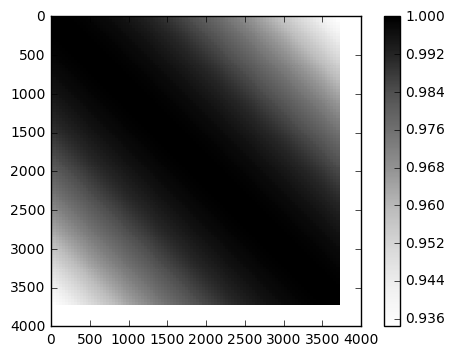

(<matplotlib.colorbar.Colorbar at 0x11428e6d0>, None, None, None)

In [42]:
#chicken scratch plot which shows the covariance matrix as a function of A and L. 
a,l=1,1e8
t = data["BJD"] - data["BJD"].iloc[0]
my_gp = george.GP(a * kernels.ExpSquaredKernel(l) )
my_gp.compute(data["RV"].values, data["Unc"].values)  # matrix needs to know the times and values of the diagonal elements
# Plotting
tm = np.linspace(t.min(),t.max(),1e2) - t.min()
plt.pcolormesh(tm, tm, my_gp.get_matrix(tm), cmap=plt.get_cmap('Greys'))
plt.colorbar(), plt.axes().set_aspect('equal'), plt.gca().invert_yaxis(), plt.show()

### emcee

In [5]:
def lnlikeGP(theta_GP, times, y, yerr):
    theta, offset = theta_GP[:11], theta_GP[11]
    A, L = np.exp(theta_GP[11:14])                  #params are in exponential space
    gp = george.GP(A*kernels.ExpSquaredKernel(L) )
    gp.compute(times,yerr)
    data = y - offset
    return gp.lnlikelihood(data - fit_RV(times,theta))

def lnpriorGP(theta_GP):
    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,offset,lnA,lnL = theta_GP
    if 0.4<m1sini<2 and 0.4<m2sini<2 and 0.2<a1<0.8 and 0.8<a2<1.4 and 0<=h1**2 + k1**2<1. and 0<=h2**2 + k2**2<1. and -1<h1<1 and -1<h2<1 and -1<k1<1 and -1<k2<1 and 0.<=lambda1<=2*np.pi and 0.<=lambda2<=2*np.pi and 0.05<=sini<=1. and -40<offset<40 and -5<lnA<5 and -5<lnL<5:
        return 0   
    return -np.inf 

def lnprobGP(theta_j, times, y, yerr):
    lnp = lnpriorGP(theta_j)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlikeGP(theta_j, times, y, yerr)

In [5]:
#initialize parameters
times = data["BJD"] - data["BJD"].iloc[0] #BJD (days)
m1sini,m2sini = 0.916,0.851               #Jupiter masses, default 0.85,0.82
a1,a2 = 0.643,1.017                       #AU, default: 0.64, 1.02
h1,h2 = 0.0366,-0.067                     
k1,k2 = -0.167,0.078                      
lambda1,lambda2 = 2.31,6.18               #in radians, default: 129, 233
sini = 0.9                                #inclination angle (0-1)
offset = 0                                #RV offset to account for forward/back motion of star (m/s)
A, expL = 1, 5                            #GP squared exp amplitude (A) and length scale (10**L)

theta_ini = [m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini,offset,A,expL]

ndim, nwalkers, n_it, n_checkpoints = len(theta_ini), 150, 2400, 4

Run the MCMC. **Warning**. This could take a while.

In [7]:
p0 = [theta_ini + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprobGP, args=(times, data["RV"].values, data["Unc"].values));
filename = "hkGP_%dwalk_%dit"%(nwalkers,n_it)

print("Running burn-in...")
pos, _, _ = sampler.run_mcmc(p0, 200)
np.save(filename+"_burnin.npy",sampler.chain)
sampler.reset()

print("Running production...")
for i in range(n_checkpoints):
    pos, _, _ = sampler.run_mcmc(pos, n_it/n_checkpoints);
    np.save(filename+"_chkpt%d.npy"%i,sampler.chain)

Running burn-in...
Running production...


# Load and analyze data

In [6]:
#Corner plot
burnin = 0

#filename="emcee_chains/hkGP_120walk_2400it_chkpt3"
filename="emcee_chains/hksemi-activeGP_120walk_2400it_chkpt3"

samples = np.load(filename+".npy")[:, burnin:, :].reshape((-1, ndim))

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)


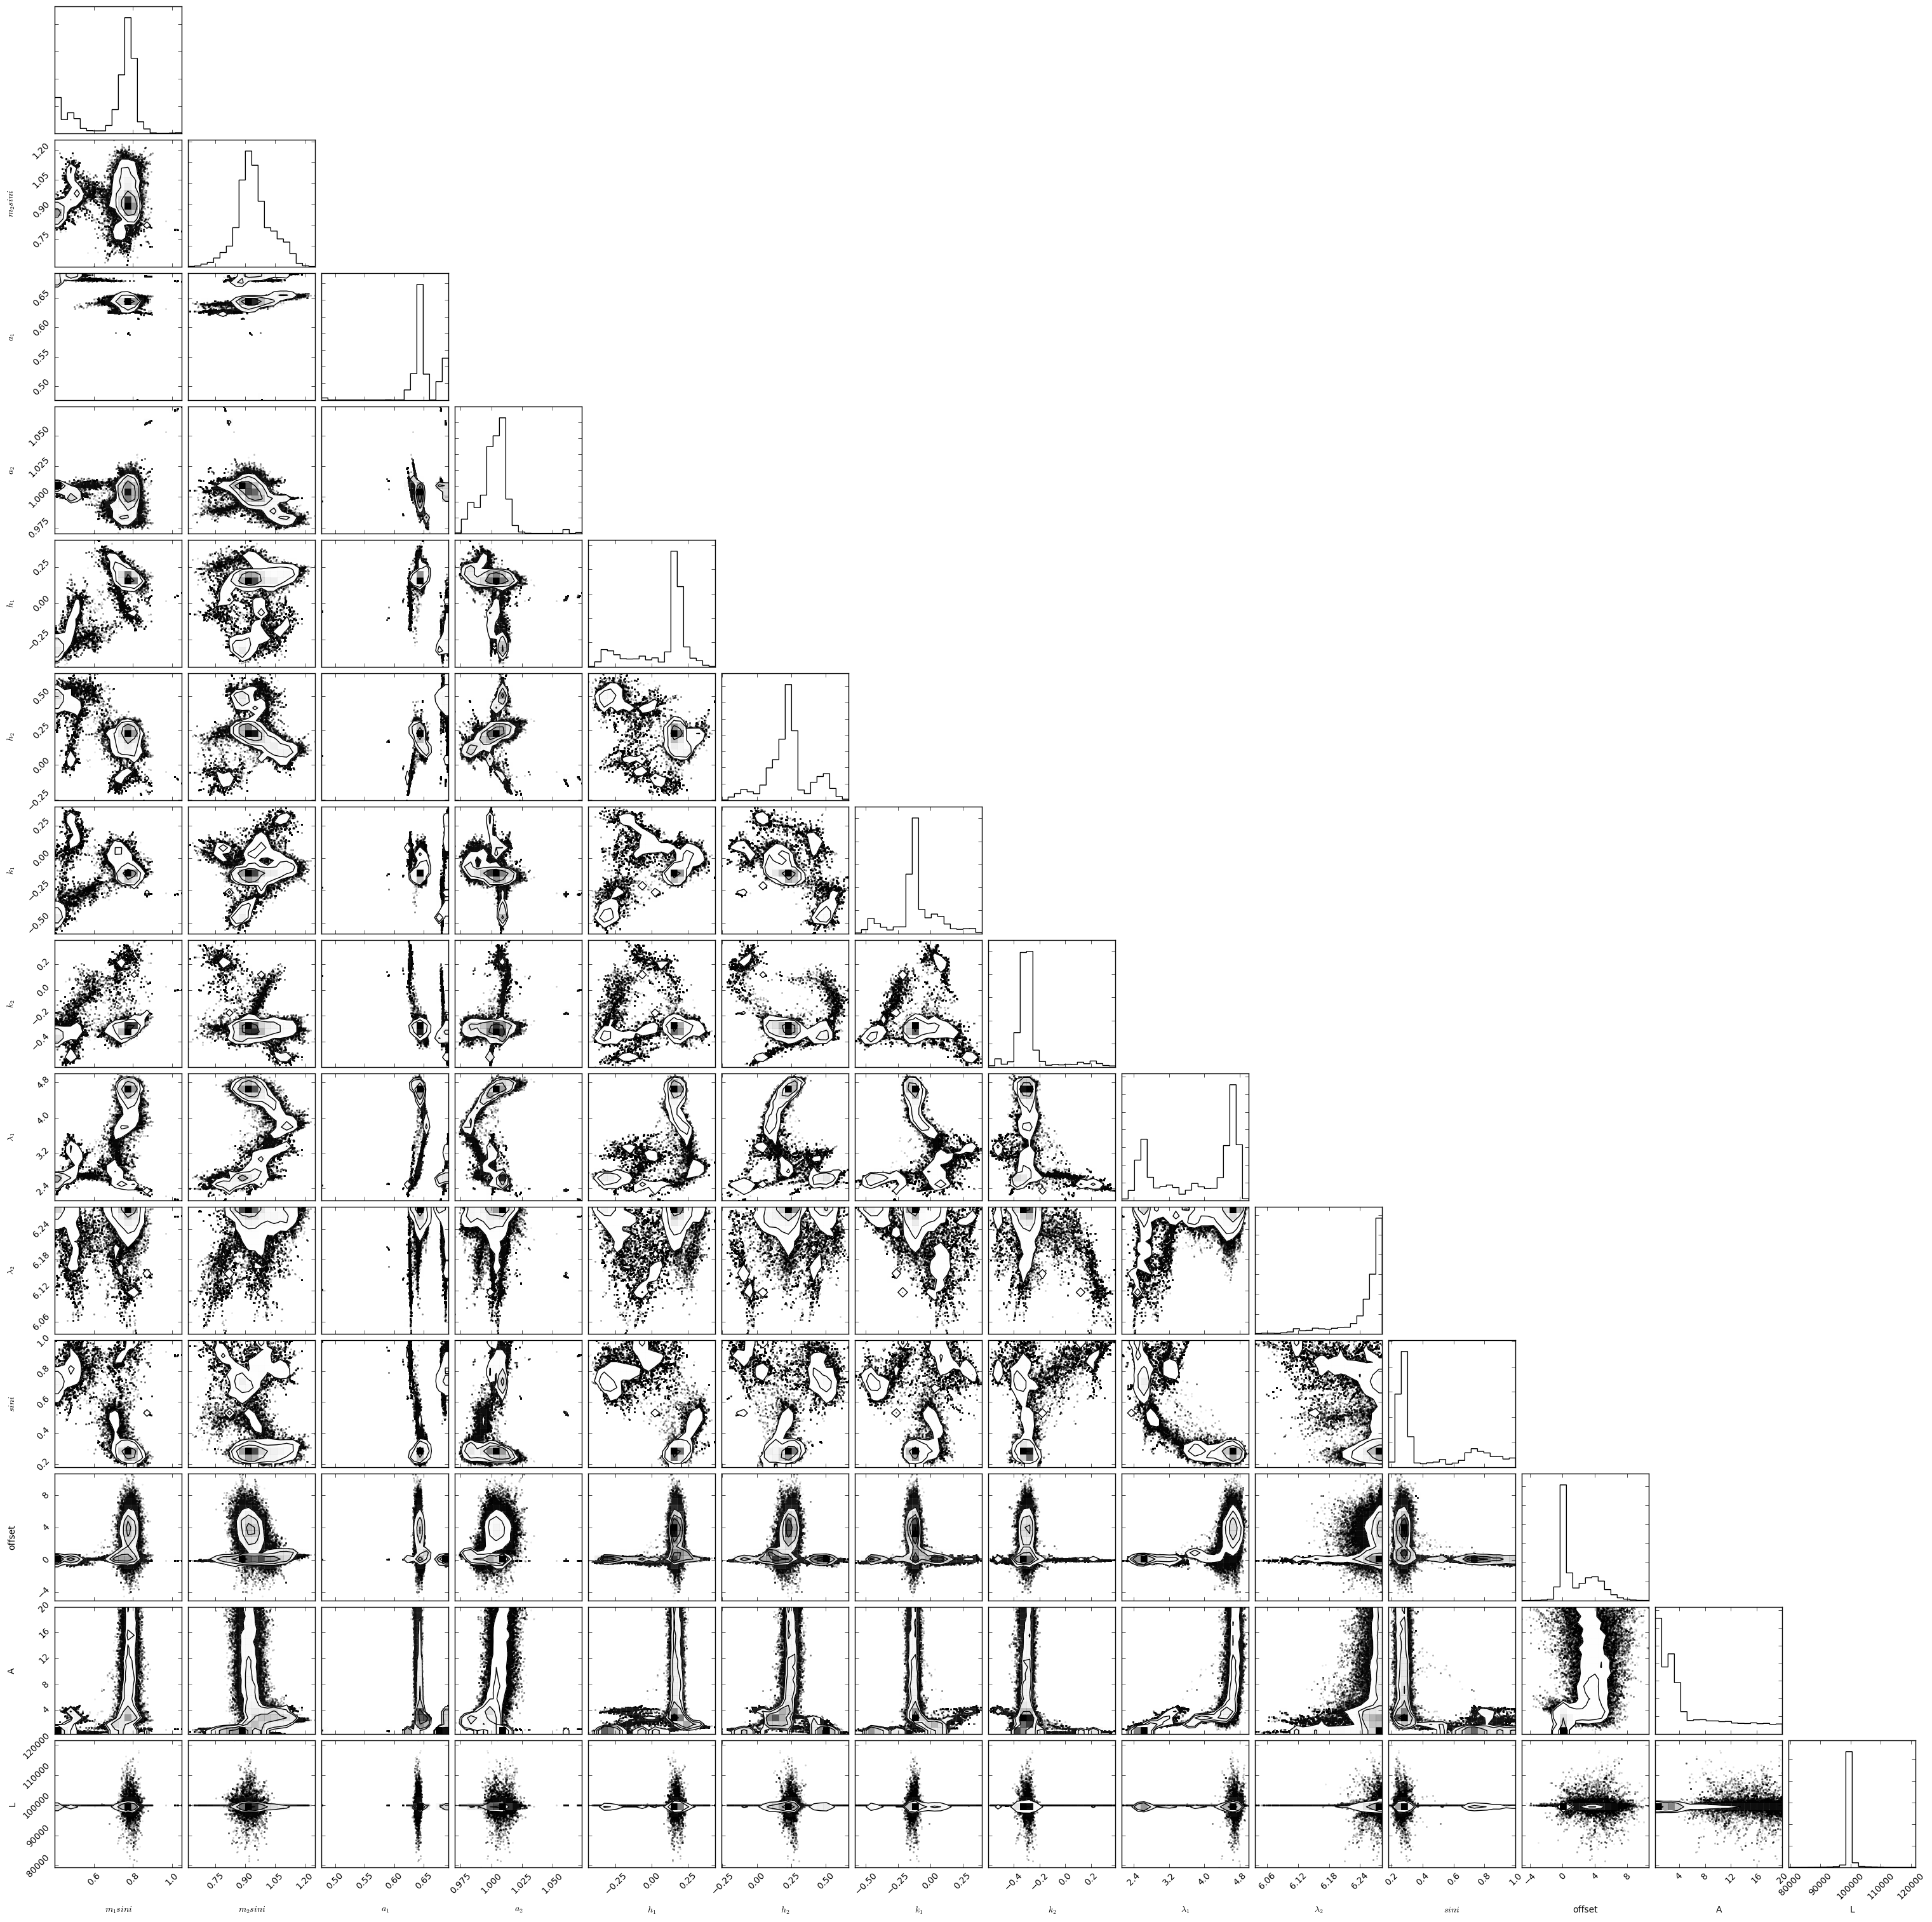

In [7]:
fig = corner.corner(samples, labels=["$m_1sini$","$m_2sini$","$a_1$","$a_2$","$h_1$","$h_2$","$k_1$","$k_2$","$\lambda_1$","$\lambda_2$","$sini$","offset","A","L"])
fig.savefig(filename+"_corner.png")

### Get/Plot MAP

In [20]:
#Better way to do this? This result could depend on the binning. 
labels=["m1sini","m2sini","a1","a2","h1","h2","k1","k2","lambd1","lambd2","sini","offset","A","L"]
MAP, std = [], []
for i in range(ndim):
    n, bins, patches = plt.hist(samples[:,i], 101, normed=1, facecolor='green', alpha=0.75);
    MAP.append(bins[np.argmax(n)])
    std.append(np.std(samples[:,i]))
plt.close()
p=zip(labels,MAP,std)
print "parameter \t MAP \t\t std"
for i in range(ndim):
    print "%s \t\t %f \t %f"%(p[i][0],p[i][1],p[i][2])

parameter 	 MAP 		 std
m1sini 		 0.921681 	 0.030530
m2sini 		 1.023880 	 0.084021
a1 		 0.643374 	 0.014416
a2 		 0.991361 	 0.037532
h1 		 0.069487 	 0.068865
h2 		 0.303784 	 0.102766
k1 		 -0.059232 	 0.061989
k2 		 0.125553 	 0.040829
lambd1 		 4.187336 	 0.563878
lambd2 		 6.279477 	 0.046301
sini 		 0.419789 	 0.148565
offset 		 -0.076078 	 2.947073
A 		 0.908881 	 5.169681
L 		 99992.902277 	 93.743548


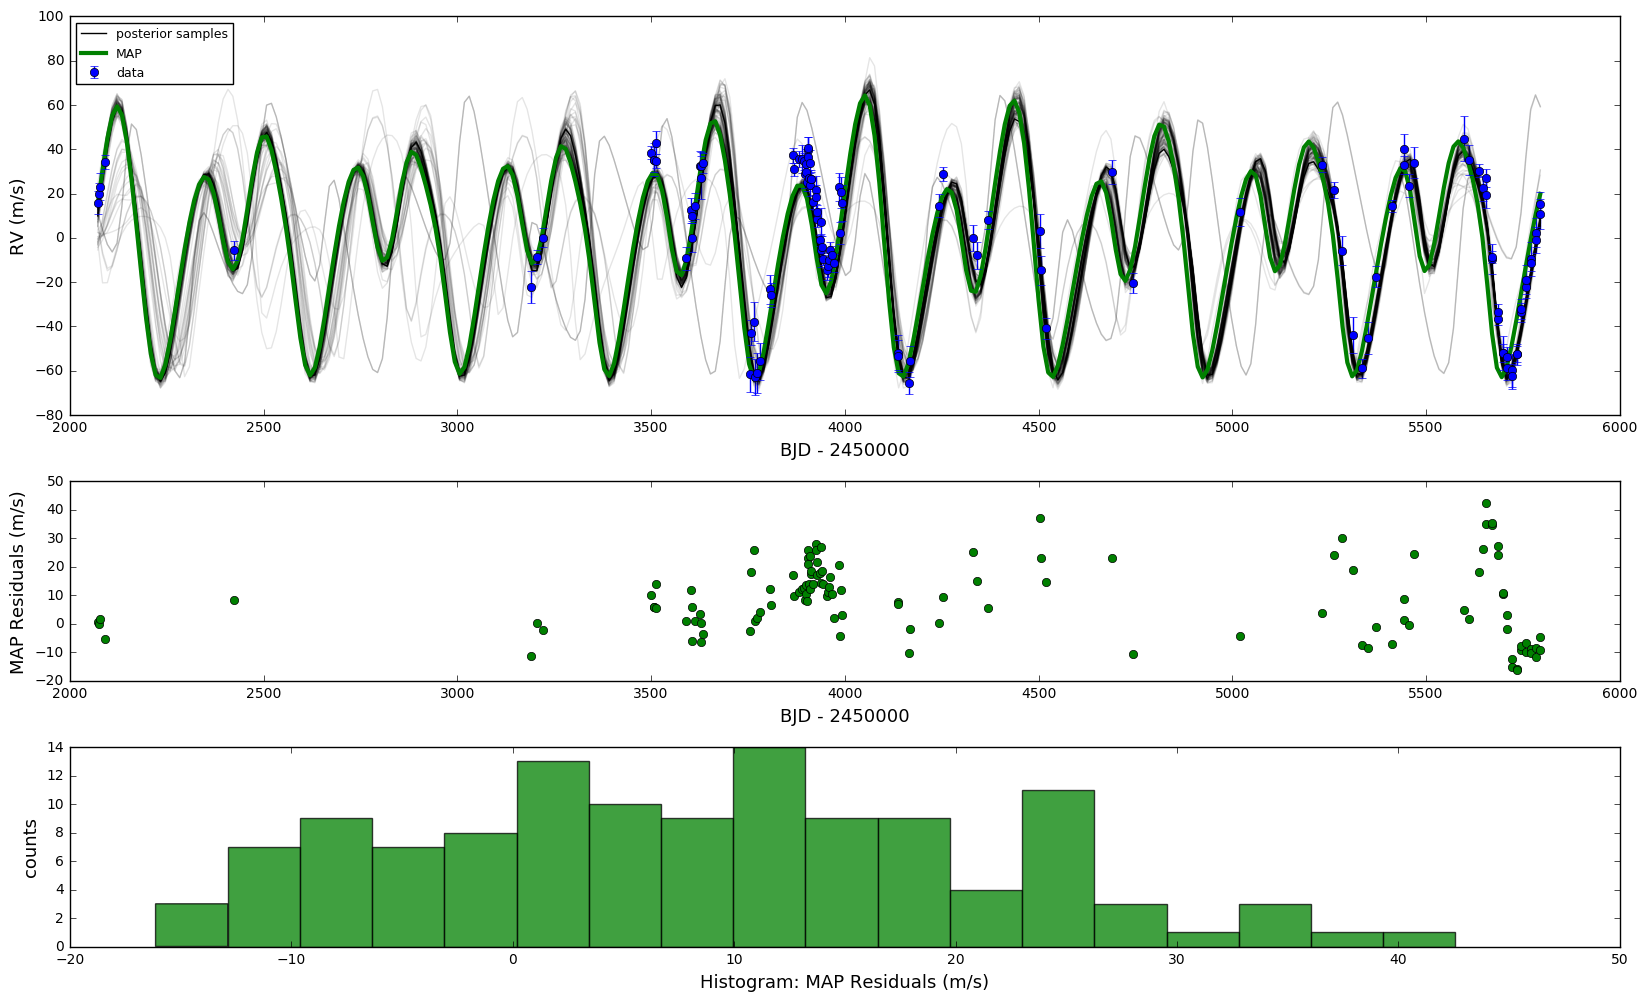

In [21]:
#plotting stuff
from matplotlib import gridspec
fontsize=13
fig = plt.figure(figsize=(20, 12))
gs = gridspec.GridSpec(3, 1, height_ratios=[2, 1, 1])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2])]
plt.subplots_adjust(hspace = 0.25)
axes[0].set_ylabel("RV (m/s)",fontsize=fontsize)
axes[0].set_xlabel("BJD - 2450000",fontsize=fontsize)
axes[1].set_ylabel("MAP Residuals (m/s)",fontsize=fontsize)
axes[1].set_xlabel("BJD - 2450000",fontsize=fontsize)
axes[2].set_ylabel("counts",fontsize=fontsize)
axes[2].set_xlabel("Histogram: MAP Residuals (m/s)",fontsize=fontsize)

#samples from posterior
t0 = data["BJD"].iloc[0]
tt = np.linspace(t0,max(data["BJD"]),300)
for theta in samples[np.random.randint(len(samples), size=100)]:
    sampleRV = fit_RV(tt-t0,theta[:11])
    axes[0].plot(tt,sampleRV,color="k", alpha=0.1)
axes[0].plot(tt,sampleRV,color="k", label='posterior samples')

#MAP
RV = fit_RV(tt-t0,MAP[:11])
Residuals = data["RV"] - fit_RV(data["BJD"] - data["BJD"].iloc[0],MAP[:11])
axes[0].plot(tt,RV, color='green',linewidth=3, label='MAP')
axes[0].errorbar(data["BJD"],data["RV"], yerr=data["Unc"], fmt='o', color='blue', label='data')
axes[1].plot(data["BJD"],Residuals, 'o', color='green')
axes[2].hist(Residuals, 18, facecolor='green', alpha=0.75);

#save
axes[0].legend(loc="upper left",fontsize=9,numpoints=1)
plt.savefig(filename+"_MAP_RV.png")

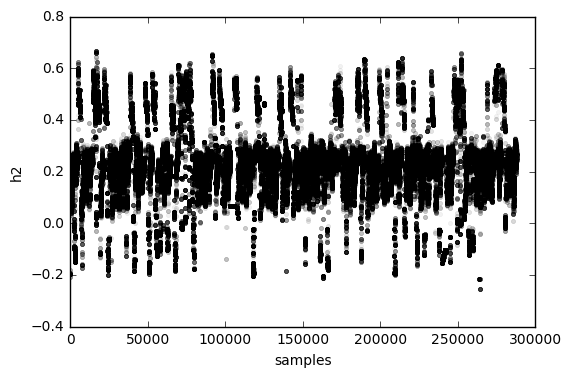

In [13]:
parameter = 5
labels=["m1sini","m2sini","a1","a2","h1","h2","k1","k2","lambda1","lambda2","sini","offset","A","L"]
plt.plot(samples[:,parameter], '.', alpha=0.05, color='black')
plt.ylabel(labels[parameter])
plt.xlabel("samples")

## Determine if system is in resonance.

In [22]:
def res_arg(sim):
    o1 = sim.particles[1].calculate_orbit(sim.particles[0])
    o2 = sim.particles[2].calculate_orbit(sim.particles[0])
    phi = 2.*o2.l - o1.l - o1.pomega
    phi2 = 2.*o2.l - o1.l - o2.pomega
    phi3 = o1.pomega - o2.pomega
    while(phi >= 2*np.pi):
        phi -= 2*np.pi
    while(phi < 0.):
        phi += 2*np.pi
    while(phi2 >= 2*np.pi):
        phi2 -= 2*np.pi
    while(phi2 < 0.):
        phi2 += 2*np.pi
    while(phi3 >= 2*np.pi):
        phi3 -= 2*np.pi
    while(phi3 < 0.):
        phi3 += 2*np.pi
    return phi, phi2, phi3

def check_resonance(theta,tmax,Npts):
    m1sini,m2sini,a1,a2,h1,h2,k1,k2,lambda1,lambda2,sini = theta
    #m1sini,m2sini,a1,a2,e1,e2,w1,w2,M1,M2,sini = theta
    AUyr2ms = 29682.77                   #AU/(yr/2pi) -> m/s
    dtoyr2pi = 2*np.pi/365.              #days -> yr/2pi
    mJ = 9.543e-4                        #Jupiter mass -> solar mass
    phi, phi2, phi3 = [], [], []
    
    sim = rebound.Simulation()
    sim.integrator = "whfast"
    sim.add(m=0.92)                      #add the star
    sim.dt = 2*np.pi* a1**(1.5) / 50.    #dt = 50 steps per orb per of inner planet
    sim.add(m=m1sini*mJ/sini,a=a1,l=lambda1,h=h1,k=k1) 
    sim.add(m=m2sini*mJ/sini,a=a2,l=lambda2,h=h2,k=k2) 
    #sim.add(m=m1sini*mJ/sini,a=a1,e=e1,omega=w1,M=M1) 
    #sim.add(m=m2sini*mJ/sini,a=a2,e=e2,omega=w2,M=M2)  
    sim.move_to_com()
    for t in np.linspace(0,tmax,Npts):
        sim.integrate(t)
        p1,p2,p3 = res_arg(sim)
        phi.append(p1), phi2.append(p2), phi3.append(p3)
    return phi, phi2, phi3

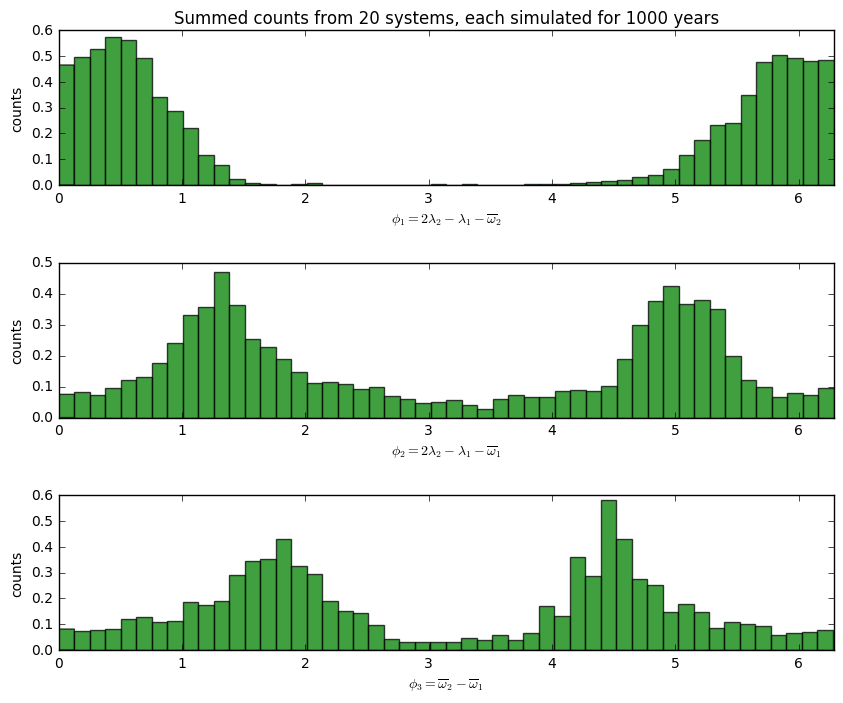

In [23]:
from matplotlib import gridspec
fontsize=13

#draw samples and see if system is in resonance
tmax = 1000
Npts = 500
Ndraws = 20
phi = []
phi2 = []
phi3 = []
for theta in samples[np.random.randint(len(samples), size=Ndraws)]:
    p1, p2, p3 = check_resonance(theta[:-1],tmax,Npts)
    phi = phi + p1
    phi2 = phi2 + p2
    phi3 = phi3 + p3

#plot
bins = 50
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 1, 1])
axes = [plt.subplot(gs[0]),plt.subplot(gs[1]),plt.subplot(gs[2])]
plt.subplots_adjust(hspace = 0.5)
axes[0].hist(phi, bins, normed=1, facecolor='green', alpha=0.75);
axes[1].hist(phi2, bins, normed=1, facecolor='green', alpha=0.75);
axes[2].hist(phi3, bins, normed=1, facecolor='green', alpha=0.75);
axes[0].set_xlabel(r'$\phi_1 = 2\lambda_2 - \lambda_1 - \overline{\omega}_2$')
axes[1].set_xlabel(r'$\phi_2 = 2\lambda_2 - \lambda_1 - \overline{\omega}_1$')
axes[2].set_xlabel(r'$\phi_3 = \overline{\omega}_2 - \overline{\omega}_1$')
axes[0].set_title('Summed counts from %d systems, each simulated for %d years'%(Ndraws,tmax))
axes[0].set_ylabel('counts')
axes[1].set_ylabel('counts')
axes[2].set_ylabel('counts')
axes[0].set_xlim([0,2*np.pi])
axes[1].set_xlim([0,2*np.pi])
axes[2].set_xlim([0,2*np.pi])
plt.savefig(filename+'_rescheck.png')